In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily
import pandas as pd
import numpy as np
from meteostat import Stations
import SNnumlib as snnl

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

RANDOM_STATE = 42

#### Taking data from 2017

In [3]:
START_DATE = '2017-01-01'
END_DATE = '2017-12-31'

stations = Stations()
stations = stations.fetch().drop(columns=['region', 'wmo', 'icao', 'elevation', 'timezone'])
stations = stations[stations['daily_start'] <= START_DATE][stations['daily_end'] >= END_DATE]

stations

,name,country,latitude,longitude,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end
id,,,,,,,,,,
00FAY,Holden Agdm,CA,53.1900,-112.2500,2020-01-01,2024-06-12,2002-11-01,2024-03-13,2003-01-01,2022-01-01
00TG6,Athabasca 1,CA,54.7200,-113.2900,NaT,NaT,2000-01-01,2022-07-12,2000-01-01,2010-01-01
01001,Jan Mayen,NO,70.9333,-8.6667,1931-01-01,2024-04-17,1921-12-31,2024-06-08,1922-01-01,2022-01-01
01002,Grahuken,NO,79.7833,14.4667,1986-11-09,2024-04-17,2010-10-07,2020-08-17,NaT,NaT
01003,Hornsund,NO,77.0000,15.5000,1985-06-01,2024-04-17,2009-11-26,2020-08-31,2016-01-01,2017-01-01
...,...,...,...,...,...,...,...,...,...,...
ZVNY0,Kitimat Townsite,CA,54.0500,-128.6300,NaT,NaT,2000-01-01,2022-08-31,2000-01-01,2018-01-01
ZWWW0,Diwopu / Urumqi / Dihua,CN,43.9000,87.4667,1985-02-09,2024-06-12,1990-08-27,2022-04-25,2006-01-01,2022-01-01
ZX07Q,Okotoks,CA,50.7300,-113.9600,NaT,NaT,2000-01-01,2022-12-02,2000-01-01,2021-01-01


#### Fetching data from meteostat daily dataset - stations in USA, MEX and CAN

In [ ]:
daily_df = []
NA_stations = stations[stations['country'].isin(['US', 'CA', 'MX'])]
for i, id in enumerate(NA_stations.index):
    print(i, len(NA_stations))
    daily_df.append(Daily(id, START_DATE,END_DATE).fetch())

#### Re-aranging main data frame to fit all data in one:
- index: stations
- columns: days

In [ ]:
merged_df = pd.DataFrame(columns=['country', 'name', 'latitude', 'longitude'] + list(daily_df[0].index.astype(str)))
merged_df['country'] = NA_stations['country']
merged_df['name'] = NA_stations['name']
merged_df['latitude'] = NA_stations['latitude']
merged_df['longitude'] = NA_stations['longitude']

j = 0
for i, daily in zip(NA_stations.index, daily_df):
    print(j, len(NA_stations))
    j += 1
    merged_df.loc[i,START_DATE:END_DATE] = daily['tavg']
        
merged_df.columns

#### Counting nans series - to avoid interpolating stations without any measurments for >10 days.

In [11]:
nans_series = []
nans_counter = 0
for row in merged_df.isna().values:
    nans_series_temp = []
    for val in row:
        if val:
            nans_counter += 1
        elif nans_counter > 0:
            nans_series_temp.append(nans_counter)
            nans_counter = 0
    
    nans_series_temp.append(nans_counter)
    nans_counter = 0
    nans_series.append(nans_series_temp)

nans_series_df = pd.DataFrame(data={'nans': merged_df.isna().sum(axis=1).values, 'nans_series': nans_series, 'max': [np.array(ser).max() for ser in nans_series]}, index=merged_df.index)
nans_series_df.head(30)

,nans,nans_series,max
id,,,
02FNZ,0,[0],0
07QNC,6,"[1, 1, 1, 3, 0]",3
087BL,11,"[1, 1, 1, 2, 2, 1, 1, 2, 0]",2
0CC8G,0,[0],0
0FV2W,5,"[1, 2, 2, 0]",2
0JGQ7,0,[0],0
0JPFS,0,[0],0
0RN07,88,"[3, 3, 4, 1, 1, 1, 2, 3, 5, 1, 1, 4, 4, 4, 5, 2, 5, 3, 3, 8, 5, 4, 5, 5, 2, 2, 2, 0]",8
0W9CU,4,"[1, 1, 1, 1, 0]",1


#### Getting rid of stations which don't have collected data at the beggining and end of the year as it imposiible to interpolate

In [12]:
def filter_stations_with_nans_recursively(df, first_days, last_days):
    previous_shape = 0
    current_shape = df.shape[0]

    while previous_shape != current_shape:
        previous_shape = current_shape
        df = df.dropna(subset=first_days, how='any').dropna(subset=last_days, how='any')
        current_shape = df.shape[0]

    return df

In [13]:
to_delete = nans_series_df[nans_series_df['max'] > 10].index

merged_df_orig = merged_df.copy()
merged_df = merged_df.drop(to_delete)

first_three_days = merged_df.columns[5:8]
last_three_days = merged_df.columns[-3:]

merged_df = filter_stations_with_nans_recursively(merged_df, first_three_days, last_three_days)

merged_df.shape, merged_df_orig.shape

((2448, 320), (2448, 320))

##### Clean data frame, deleted ~ 1000 stations, so far so good

In [14]:
merged_df

,country,name,latitude,longitude,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,2017-01-11,2017-01-12,2017-01-13,2017-01-14,2017-01-16,2017-01-17,2017-01-18,2017-01-19,2017-01-20,2017-01-21,2017-01-26,2017-01-27,2017-01-28,2017-01-29,2017-01-30,2017-01-31,2017-02-01,2017-02-02,2017-02-03,2017-02-04,2017-02-05,2017-02-07,2017-02-08,2017-02-09,2017-02-11,2017-02-13,2017-02-15,2017-02-17,2017-02-18,2017-02-19,2017-02-20,2017-02-21,2017-02-22,2017-02-23,2017-02-24,2017-02-25,2017-02-26,2017-02-27,2017-02-28,2017-03-01,2017-03-02,2017-03-03,2017-03-04,2017-03-05,2017-03-06,2017-03-07,2017-03-08,2017-03-09,2017-03-11,2017-03-12,2017-03-13,2017-03-14,2017-03-17,2017-03-19,2017-03-20,2017-03-21,2017-03-22,2017-03-23,2017-03-24,2017-03-25,2017-03-26,2017-03-27,2017-03-28,2017-03-29,2017-03-30,2017-03-31,2017-04-01,2017-04-02,2017-04-03,2017-04-04,2017-04-05,2017-04-06,2017-04-07,2017-04-08,2017-04-09,2017-04-10,2017-04-11,2017-04-12,2017-04-14,2017-04-15,2017-04-16,2017-04-18,2017-04-19,2017-04-20,2017-04-21,2017-04-22,2017-04-23,2017-04-24,2017-04-25,2017-04-26,2017-04-28,2017-04-29,2017-04-30,2017-05-01,2017-05-02,2017-05-03,2017-05-04,2017-05-05,2017-05-06,2017-05-07,2017-05-08,2017-05-09,2017-05-10,2017-05-11,2017-05-12,2017-05-13,2017-05-14,2017-05-15,2017-05-16,2017-05-17,2017-05-18,2017-05-19,2017-05-20,2017-05-21,2017-05-22,2017-05-23,2017-05-24,2017-05-25,2017-05-26,2017-05-27,2017-05-28,2017-05-29,2017-05-30,2017-05-31,2017-06-01,2017-06-02,2017-06-03,2017-06-04,2017-06-05,2017-06-06,2017-06-07,2017-06-08,2017-06-09,2017-06-10,2017-06-11,2017-06-12,2017-06-13,2017-06-15,2017-06-17,2017-06-19,2017-06-20,2017-06-21,2017-06-23,2017-06-24,2017-06-25,2017-06-29,2017-07-01,2017-07-02,2017-07-03,2017-07-04,2017-07-05,2017-07-06,2017-07-07,2017-07-08,2017-07-09,2017-07-13,2017-07-15,2017-07-16,2017-07-17,2017-07-18,2017-07-19,2017-07-20,2017-07-21,2017-07-22,2017-07-23,2017-07-24,2017-07-25,2017-07-26,2017-07-27,2017-07-29,2017-07-30,2017-07-31,2017-08-01,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10,2017-09-11,2017-09-12,2017-09-13,2017-09-14,2017-09-15,2017-09-16,2017-09-17,2017-09-18,2017-09-19,2017-09-20,2017-09-21,2017-09-22,2017-09-23,2017-09-24,2017-09-25,2017-09-26,2017-09-27,2017-09-28,2017-09-29,2017-09-30,2017-10-01,2017-10-02,2017-10-03,2017-10-04,2017-10-05,2017-10-06,2017-10-07,2017-10-08,2017-10-09,2017-10-10,2017-10-11,2017-10-12,2017-10-13,2017-10-14,2017-10-15,2017-10-16,2017-10-19,2017-10-20,2017-10-23,2017-10-25,2017-10-26,2017-10-27,2017-10-28,2017-10-29,2017-10-31,2017-11-02,2017-11-03,2017-11-04,2017-11-06,2017-11-08,2017-11-10,2017-11-11,2017-11-13,2017-11-14,2017-11-15,2017-11-16,2017-11-18,2017-11-19,2017-11-20,2017-11-21,2017-11-22,2017-11-23,2017-11-24,2017-11-25,2017-11-26,2017-11-27,2017-11-28,2017-11-29,2017-11-30,2017-12-01,2017-12-02,2017-12-03,2017-12-08,2017-12-09,2017-12-10,2017-12-11,2017-12-12,2017-12-13,2017-12-14,2017-12-15,2017-12-16,2017-12-17,2017-12-18,2017-12-19,2017-12-20,2017-12-21,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-31
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
02FNZ,CA,Kananaskis,51.03,-115.03,-13.0,-23.0,-25.5,-19.3,-12.0,-10.3,-17.0,-22.3,-22.8,-19.8,-22.8,-16.0,-12.5,-5.0,2.0,9.0,7.0,5.0,-0.5,-7.5,-8.0,-1.0,6.0,5.5,-0.5,-1

### First interpolation:
- every NaN is interpolated from 2 previous and 2 next records
- if these neighbors are also NaNs then algorithm keep seeking further

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


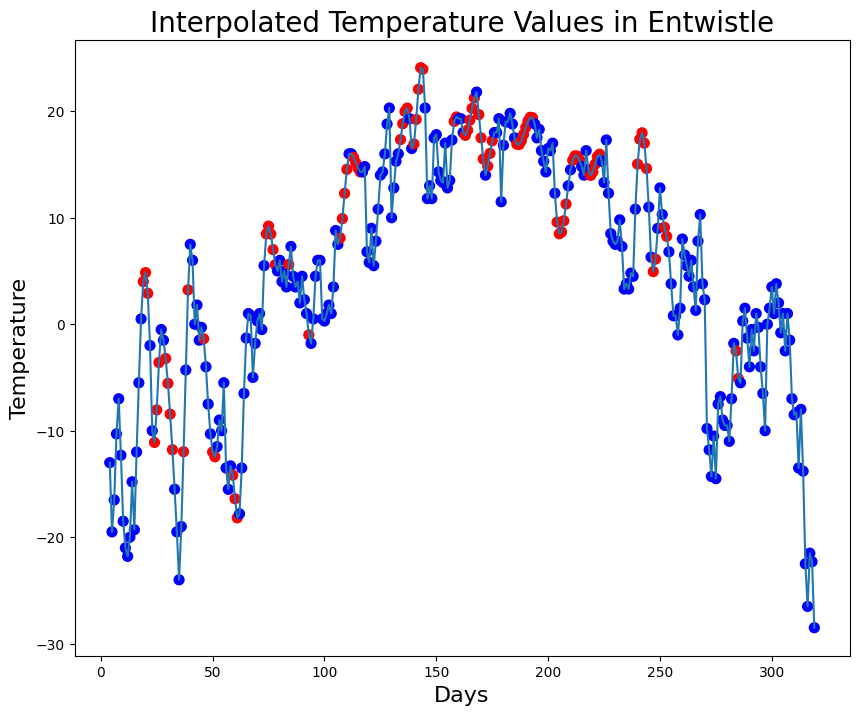

0             CA
1      Entwistle
2           53.6
3        -114.98
4          -13.0
         ...    
315        -22.5
316        -26.5
317        -21.5
318        -22.3
319        -28.5
Name: 0RN07, Length: 320, dtype: object

In [15]:
def interpolate_and_plot(df, row_index, p = False):
    nans_ind = np.arange(len(df.columns))[df.isna().iloc[row_index, :]]

    mask = []

    for id in nans_ind:
        left_stop = id - 1
        left_start = id - 2
        while left_stop in nans_ind:
            left_stop -= 1
        while left_start in nans_ind or left_start == left_stop:
            left_start -= 1
        if left_start > left_stop:
            temp = left_stop
            left_stop = left_start
            left_start = temp
        right_start = id + 1
        right_stop = id + 2
        while right_stop in nans_ind:
            right_stop += 1
        while right_start in nans_ind or right_start == right_stop:
            right_start += 1
        if right_start > right_stop:
            temp = right_stop
            right_stop = right_start
            right_start = temp
        if right_stop >= len(df.columns):
            right_stop = len(df.columns) - 1

        mask.append(np.array([left_start, left_stop, right_start, right_stop]))

    #print(nans_ind)
    #print(mask)
    test_interpolation = df.iloc[row_index, :]

    colors = test_interpolation.isna().apply(lambda x: 'red' if x else 'blue').values

    for m, n in zip(mask, nans_ind):
        test_interpolation.iloc[n] = snnl.lagrange_interpolation(m, test_interpolation.iloc[m].values, n)

    test_interpolation = test_interpolation.reset_index(drop=True)

    if p:
        plt.figure(figsize=(10, 8))
        plt.plot(test_interpolation.index[4:], test_interpolation.values[4:], label='Temperature Values')
        plt.scatter(test_interpolation.index[4:], test_interpolation.values[4:], c=colors[4:], s=50, label='Interpolated Values')

        plt.title(f'Interpolated Temperature Values in {df.name[row_index]}', fontsize=20)
        plt.ylabel('Temperature', fontsize=16)
        plt.xlabel('Days', fontsize=16)
        plt.show()

    return test_interpolation
    

interpolate_and_plot(merged_df, 7, True)

In [ ]:
itr_df = merged_df.copy()

for i in range(merged_df.shape[0]):
    print(i, '/', merged_df.shape[0])
    itr_df.iloc[i, :] = interpolate_and_plot(merged_df, i)

itr_df.head(50)

#### Plot of left stations

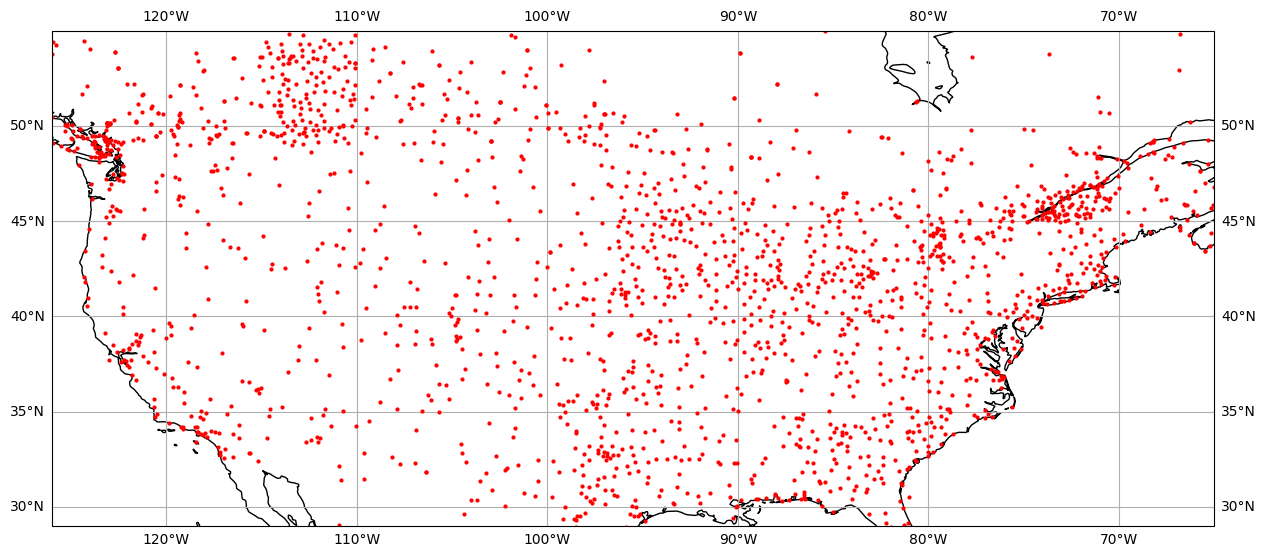

In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as crt
import cartopy.feature as cf
import geopandas as gpd

from shapely.geometry import Polygon, LineString, Point


proj = crt.PlateCarree() 
fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(15, 30))

ax.set_extent([-126, -65, 29, 55], crs=crt.PlateCarree())
ax.add_feature(cf.COASTLINE, edgecolor='black', linewidth=1)
ax.gridlines(draw_labels=True)

lon, lat = itr_df['longitude'].values, itr_df['latitude'].values 
ax.plot(lon,lat,  'bo', markersize=2, color = 'red', transform=crt.Geodetic())

#### Tightening the area to a rectangle, -400 stations

In [18]:
box_df = itr_df[itr_df['latitude'] > 29][itr_df['latitude'] < 55][itr_df['longitude'] > -126][itr_df['longitude'] < -65]
box_df.shape

(2010, 320)

#### Creating grid for second interpolation, one step - 0.5 degree

In [19]:
from shapely.geometry import Point, Polygon
import geopandas as gpd

ld = (-126, 29)
lg = (-126, 55)
pd_ = (-65, 29)
pg = (-65, 55)

x_range = [round(x,1) for x in np.arange(int(ld[0]), int(pg[0]) + 1, 0.5)]
y_range = [round(y,1) for y in np.arange(int(ld[1]), int(lg[1]) + 1, 0.5)]


grid = pd.DataFrame(columns=x_range, index=y_range[::-1])
grid

,-126.0,-125.5,-125.0,-124.5,-124.0,-123.5,-123.0,-122.5,-122.0,-121.5,-121.0,-120.5,-120.0,-119.5,-119.0,-118.5,-118.0,-117.5,-117.0,-116.5,-116.0,-115.5,-115.0,-114.5,-114.0,-113.5,-113.0,-112.5,-112.0,-111.5,-111.0,-110.5,-110.0,-109.5,-109.0,-108.5,-108.0,-107.5,-107.0,-106.5,-106.0,-105.5,-105.0,-104.5,-104.0,-103.5,-103.0,-102.5,-102.0,-101.5,-101.0,-100.5,-100.0,-99.5,-99.0,-98.5,-98.0,-97.5,-97.0,-96.5,-96.0,-95.5,-95.0,-94.5,-94.0,-93.5,-93.0,-92.5,-92.0,-91.5,-91.0,-90.5,-90.0,-89.5,-89.0,-88.5,-88.0,-87.5,-87.0,-86.5,-86.0,-85.5,-85.0,-84.5,-84.0,-83.5,-83.0,-82.5,-82.0,-81.5,-81.0,-80.5,-80.0,-79.5,-79.0,-78.5,-78.0,-77.5,-77.0,-76.5,-76.0,-75.5,-75.0,-74.5,-74.0,-73.5,-73.0,-72.5,-72.0,-71.5,-71.0,-70.5,-70.0,-69.5,-69.0,-68.5,-68.0,-67.5,-67.0,-66.5,-66.0,-65.5,-65.0,-64.5
55.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

#### Rounding stations cords to match with the grid, removing duplicates, 1500 stations left

In [20]:
shaped_df = box_df.copy()
shaped_df['latitude'] = box_df['latitude'].apply(lambda x: round(x * 2) / 2)
shaped_df['longitude'] = box_df['longitude'].apply(lambda x: round(x * 2) / 2)
shaped_df = shaped_df.drop_duplicates(subset=['latitude', 'longitude']).drop(columns=shaped_df.columns[:2])
shaped_df

,latitude,longitude,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,2017-01-11,2017-01-12,2017-01-13,2017-01-14,2017-01-16,2017-01-17,2017-01-18,2017-01-19,2017-01-20,2017-01-21,2017-01-26,2017-01-27,2017-01-28,2017-01-29,2017-01-30,2017-01-31,2017-02-01,2017-02-02,2017-02-03,2017-02-04,2017-02-05,2017-02-07,2017-02-08,2017-02-09,2017-02-11,2017-02-13,2017-02-15,2017-02-17,2017-02-18,2017-02-19,2017-02-20,2017-02-21,2017-02-22,2017-02-23,2017-02-24,2017-02-25,2017-02-26,2017-02-27,2017-02-28,2017-03-01,2017-03-02,2017-03-03,2017-03-04,2017-03-05,2017-03-06,2017-03-07,2017-03-08,2017-03-09,2017-03-11,2017-03-12,2017-03-13,2017-03-14,2017-03-17,2017-03-19,2017-03-20,2017-03-21,2017-03-22,2017-03-23,2017-03-24,2017-03-25,2017-03-26,2017-03-27,2017-03-28,2017-03-29,2017-03-30,2017-03-31,2017-04-01,2017-04-02,2017-04-03,2017-04-04,2017-04-05,2017-04-06,2017-04-07,2017-04-08,2017-04-09,2017-04-10,2017-04-11,2017-04-12,2017-04-14,2017-04-15,2017-04-16,2017-04-18,2017-04-19,2017-04-20,2017-04-21,2017-04-22,2017-04-23,2017-04-24,2017-04-25,2017-04-26,2017-04-28,2017-04-29,2017-04-30,2017-05-01,2017-05-02,2017-05-03,2017-05-04,2017-05-05,2017-05-06,2017-05-07,2017-05-08,2017-05-09,2017-05-10,2017-05-11,2017-05-12,2017-05-13,2017-05-14,2017-05-15,2017-05-16,2017-05-17,2017-05-18,2017-05-19,2017-05-20,2017-05-21,2017-05-22,2017-05-23,2017-05-24,2017-05-25,2017-05-26,2017-05-27,2017-05-28,2017-05-29,2017-05-30,2017-05-31,2017-06-01,2017-06-02,2017-06-03,2017-06-04,2017-06-05,2017-06-06,2017-06-07,2017-06-08,2017-06-09,2017-06-10,2017-06-11,2017-06-12,2017-06-13,2017-06-15,2017-06-17,2017-06-19,2017-06-20,2017-06-21,2017-06-23,2017-06-24,2017-06-25,2017-06-29,2017-07-01,2017-07-02,2017-07-03,2017-07-04,2017-07-05,2017-07-06,2017-07-07,2017-07-08,2017-07-09,2017-07-13,2017-07-15,2017-07-16,2017-07-17,2017-07-18,2017-07-19,2017-07-20,2017-07-21,2017-07-22,2017-07-23,2017-07-24,2017-07-25,2017-07-26,2017-07-27,2017-07-29,2017-07-30,2017-07-31,2017-08-01,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10,2017-09-11,2017-09-12,2017-09-13,2017-09-14,2017-09-15,2017-09-16,2017-09-17,2017-09-18,2017-09-19,2017-09-20,2017-09-21,2017-09-22,2017-09-23,2017-09-24,2017-09-25,2017-09-26,2017-09-27,2017-09-28,2017-09-29,2017-09-30,2017-10-01,2017-10-02,2017-10-03,2017-10-04,2017-10-05,2017-10-06,2017-10-07,2017-10-08,2017-10-09,2017-10-10,2017-10-11,2017-10-12,2017-10-13,2017-10-14,2017-10-15,2017-10-16,2017-10-19,2017-10-20,2017-10-23,2017-10-25,2017-10-26,2017-10-27,2017-10-28,2017-10-29,2017-10-31,2017-11-02,2017-11-03,2017-11-04,2017-11-06,2017-11-08,2017-11-10,2017-11-11,2017-11-13,2017-11-14,2017-11-15,2017-11-16,2017-11-18,2017-11-19,2017-11-20,2017-11-21,2017-11-22,2017-11-23,2017-11-24,2017-11-25,2017-11-26,2017-11-27,2017-11-28,2017-11-29,2017-11-30,2017-12-01,2017-12-02,2017-12-03,2017-12-08,2017-12-09,2017-12-10,2017-12-11,2017-12-12,2017-12-13,2017-12-14,2017-12-15,2017-12-16,2017-12-17,2017-12-18,2017-12-19,2017-12-20,2017-12-21,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-31
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
02FNZ,51.0,-115.0,-13.0,-23.0,-25.5,-19.3,-12.0,-10.3,-17.0,-22.3,-22.8,-19.8,-22.8,-16.0,-12.5,-5.0,2.0,9.0,7.0,5.0,-0.5,-7.5,-8.0,-1.0,6.0,5.5,-0.5,-10.5,-11.8,-16.0,-15.8,-16.8,-17

In [218]:
shaped_df.to_csv('shaped.csv')

#### Overlaying stations data to the grid

In [21]:
grids = []
for date in shaped_df.columns[2:4]:
    print(date)
    temp_grid = grid.copy()
    for x in grid.index.astype(float):
        for y in grid.columns.astype(float):
            if (x, y) in zip(shaped_df['latitude'].values, shaped_df['longitude'].values):
                temp_grid.loc[x, y] = shaped_df[(shaped_df['latitude'] == x) & (shaped_df['longitude'] == y)][date].values[0]
    grids.append(temp_grid)
grids[0]

2017-01-01
2017-01-02


,-126.0,-125.5,-125.0,-124.5,-124.0,-123.5,-123.0,-122.5,-122.0,-121.5,-121.0,-120.5,-120.0,-119.5,-119.0,-118.5,-118.0,-117.5,-117.0,-116.5,-116.0,-115.5,-115.0,-114.5,-114.0,-113.5,-113.0,-112.5,-112.0,-111.5,-111.0,-110.5,-110.0,-109.5,-109.0,-108.5,-108.0,-107.5,-107.0,-106.5,-106.0,-105.5,-105.0,-104.5,-104.0,-103.5,-103.0,-102.5,-102.0,-101.5,-101.0,-100.5,-100.0,-99.5,-99.0,-98.5,-98.0,-97.5,-97.0,-96.5,-96.0,-95.5,-95.0,-94.5,-94.0,-93.5,-93.0,-92.5,-92.0,-91.5,-91.0,-90.5,-90.0,-89.5,-89.0,-88.5,-88.0,-87.5,-87.0,-86.5,-86.0,-85.5,-85.0,-84.5,-84.0,-83.5,-83.0,-82.5,-82.0,-81.5,-81.0,-80.5,-80.0,-79.5,-79.0,-78.5,-78.0,-77.5,-77.0,-76.5,-76.0,-75.5,-75.0,-74.5,-74.0,-73.5,-73.0,-72.5,-72.0,-71.5,-71.0,-70.5,-70.0,-69.5,-69.0,-68.5,-68.0,-67.5,-67.0,-66.5,-66.0,-65.5,-65.0,-64.5
55.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-12.4,-17.0,NaN,NaN,NaN,NaN,NaN,-13.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-19.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-30.7,NaN,NaN,NaN,NaN,NaN
54.5,-18.6,NaN,NaN,-13.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-13.9,NaN,-17.6,NaN,-16.8,-15.3,NaN,-16.7,-17.4,-16.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54.0,-19.5,NaN,NaN,NaN,-10.3,NaN,NaN,-14.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-20.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-12.7,-15.6,NaN,-16.2,-17.0,-17.8,-14.1,NaN,NaN,NaN,NaN,-18.7,-19.2,NaN,NaN,NaN,NaN,-17.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-17.6,NaN,NaN,NaN,NaN,NaN,-23.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-20.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-18.3,NaN,NaN,NaN,-16.2,NaN,NaN,-13.0,NaN,-13.2,-9.0,-16.3,-15.2,-17.9,-15.2,NaN,-16.3,-16.0,NaN,-15.3,NaN,NaN,-19.5,NaN,NaN,NaN,NaN,NaN,NaN,-15.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-21.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-14.7,NaN,NaN,NaN,NaN,NaN,-14.5,-12.9,-15.0,NaN,-16.5,-16.5,-17.1,NaN,-17.5,-12.6,-16.8,NaN,NaN,-17.7,-17.4,NaN,NaN,NaN,NaN,-18.6,NaN,-17.4,NaN,NaN,NaN,-16.7,NaN,NaN,-15.8,NaN,NaN,-17.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-33.7,NaN,NaN,NaN,NaN,NaN
52.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [201]:
for i in range(len(grids)):
    grids[i] = grids[i].apply(pd.to_numeric, errors='coerce')

### Second interpolation:
- conducted in 2D space
- with usage of scipy.interpolate.griddata function

In [216]:
from scipy.interpolate import griddata

x, y = np.meshgrid(grids[0].columns, grids[0].index)
x = x.flatten()
y = y.flatten()
z = grids[0].values.flatten()

mask = ~np.isnan(z)
x = x[mask]
y = y[mask]

xi, yi = np.meshgrid(grids[0].columns, grids[0].index)

final_dfs = []

for i, grid in enumerate(grids):
    print(i, '/', len(grids))
    z = grid.values.flatten()
    z = z[mask]
    zi = griddata((x, y), z, (xi, yi), method='linear')
    final_dfs.append(pd.DataFrame(zi, index=test_grid.index, columns=test_grid.columns))

final_dfs[0]

0 / 316
1 / 316
2 / 316
3 / 316
4 / 316
5 / 316
6 / 316
7 / 316
8 / 316
9 / 316
10 / 316
11 / 316
12 / 316
13 / 316
14 / 316
15 / 316
16 / 316
17 / 316
18 / 316
19 / 316
20 / 316
21 / 316
22 / 316
23 / 316
24 / 316
25 / 316
26 / 316
27 / 316
28 / 316
29 / 316
30 / 316
31 / 316
32 / 316
33 / 316
34 / 316
35 / 316
36 / 316
37 / 316
38 / 316
39 / 316
40 / 316
41 / 316
42 / 316
43 / 316
44 / 316
45 / 316
46 / 316
47 / 316
48 / 316
49 / 316
50 / 316
51 / 316
52 / 316
53 / 316
54 / 316
55 / 316
56 / 316
57 / 316
58 / 316
59 / 316
60 / 316
61 / 316
62 / 316
63 / 316
64 / 316
65 / 316
66 / 316
67 / 316
68 / 316
69 / 316
70 / 316
71 / 316
72 / 316
73 / 316
74 / 316
75 / 316
76 / 316
77 / 316
78 / 316
79 / 316
80 / 316
81 / 316
82 / 316
83 / 316
84 / 316
85 / 316
86 / 316
87 / 316
88 / 316
89 / 316
90 / 316
91 / 316
92 / 316
93 / 316
94 / 316
95 / 316
96 / 316
97 / 316
98 / 316
99 / 316
100 / 316
101 / 316
102 / 316
103 / 316
104 / 316
105 / 316
106 / 316
107 / 316
108 / 316
109 / 316
110 / 316


,-126.0,-125.5,-125.0,-124.5,-124.0,-123.5,-123.0,-122.5,-122.0,-121.5,-121.0,-120.5,-120.0,-119.5,-119.0,-118.5,-118.0,-117.5,-117.0,-116.5,-116.0,-115.5,-115.0,-114.5,-114.0,-113.5,-113.0,-112.5,-112.0,-111.5,-111.0,-110.5,-110.0,-109.5,-109.0,-108.5,-108.0,-107.5,-107.0,-106.5,-106.0,-105.5,-105.0,-104.5,-104.0,-103.5,-103.0,-102.5,-102.0,-101.5,-101.0,-100.5,-100.0,-99.5,-99.0,-98.5,-98.0,-97.5,-97.0,-96.5,-96.0,-95.5,-95.0,-94.5,-94.0,-93.5,-93.0,-92.5,-92.0,-91.5,-91.0,-90.5,-90.0,-89.5,-89.0,-88.5,-88.0,-87.5,-87.0,-86.5,-86.0,-85.5,-85.0,-84.5,-84.0,-83.5,-83.0,-82.5,-82.0,-81.5,-81.0,-80.5,-80.0,-79.5,-79.0,-78.5,-78.0,-77.5,-77.0,-76.5,-76.0,-75.5,-75.0,-74.5,-74.0,-73.5,-73.0,-72.5,-72.0,-71.5,-71.0,-70.5,-70.0,-69.5,-69.0,-68.5,-68.0,-67.5,-67.0,-66.5,-66.0,-65.5,-65.0,-64.5
55.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-12.400000,-17.000000,-16.366667,-15.733333,-15.100000,-14.466667,-13.833333,-13.200000,-13.612500,-14.025000,-14.437500,-14.850000,-15.262500,-15.675000,-16.087500,-16.500000,-16.912500,-17.325000,-17.737500,-18.150000,-18.562500,-18.975000,-19.387500,-19.800000,-19.896970,-19.993939,-20.090909,-20.187879,-20.284848,-20.381818,-20.478788,-20.575758,-20.672727,-20.769697,-20.866667,-20.963636,-21.060606,-21.157576,-21.254545,-2.135152e+01,-21.448485,-21.545455,-21.642424,-21.739394,-21.836364,-21.933333,-22.030303,-22.127273,-22.224242,-22.321212,-22.418182,-22.515152,-22.612121,-22.709091,-22.806061,-22.903030,-23.000000,-23.208108,-23.416216,-23.624324,-23.832432,-24.040541,-24.248649,-24.456757,-24.664865,-24.872973,-25.081081,-25.289189,-25.497297,-25.705405,-25.913514,-26.121622,-26.329730,-26.537838,-26.745946,-26.954054,-27.162162,-27.370270,-27.578378,-27.786486,-27.994595,-28.202703,-28.410811,-28.618919,-28.827027,-29.035135,-29.243243,-29.451351,-29.659459,-29.867568,-30.075676,-30.283784,-30.491892,-30.700000,NaN,NaN,NaN,NaN,NaN
54.5,-18.6,-17.000000,-15.400000,-13.800000,-13.961765,-14.123529,-14.285294,-14.447059,-14.608824,-14.770588,-14.932353,-15.094118,-15.255882,-15.417647,-15.579412,-15.741176,-15.902941,-16.064706,-16.226471,-16.388235,-16.550000,-15.225000,-13.900000,-15.750000,-17.600000,-17.200000,-16.800000,-15.300000,-16.000000,-16.700000,-17.400000,-16.500000,-14.133333,-15.950000,-16.040000,-15.720000,-15.400000,-15.812500,-16.225000,-16.637500,-17.050000,-17.462500,-17.875000,-18.287500,-18.700000,-18.562500,-18.425000,-18.546154,-19.020000,-19.000000,-19.816667,-20.633333,-21.450000,-21.275000,-21.100000,-20.925000,-20.750000,-20.575000,-20.400000,-20.225000,-20.050000,-20.146970,-20.243939,-20.340909,-2.043788e+01,-20.534848,-20.631818,-20.728788,-20.825758,-20.922727,-21.019697,-21.116667,-21.213636,-21.310606,-21.407576,-21.504545,-21.601515,-21.361364,-20.784091,-20.206818,-19.629545,-22.090323,-22.269620,-22.429268,-22.430488,-22.431707,-22.432927,-22.465000,-22.512500,-22.560000,-22.607500,-22.655000,-22.702500,-22.750000,-22.958108,-23.166216,-23.374324,-23.582432,-23.790541,-23.998649,-24.206757,-24.414865,-24.622973,-24.831081,-25.039189,-25.247297,-25.455405,-25.663514,-25.871622,-26.079730,-26.287838,-26.495946,-26.932000,-27.596000,-28.260000,-28.924000,-29.588000,-30.318750,-31.450000,NaN,NaN,NaN,NaN,NaN
54.0,-19.5,-17.200000,-14.900000,-12.600000,-10.300000,-11.600000,-12.900000,-14.200000,-15.012500,-15.825000,-16.637500,-17.450000,-18.262500,-19.075000,-19.887500,-20.700000,-19.672727,-18.645455,-17.61818

#### These are our final results so we can save them

In [217]:
import zipfile
import os

for i, df in enumerate(final_dfs):
    df.to_csv(f'df{i}.csv')

with zipfile.ZipFile('dataframes.zip', 'w') as zipf:
    
    for i in range(len(final_dfs)):
        zipf.write(f'df{i}.csv')

for i in range(len(final_dfs)):
    os.remove(f'df{i}.csv')